In [80]:
import sqlalchemy 
import psycopg2 
import random
import pandas as pd
import datetime as dt
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 
import pyschedule
from pyschedule import Scenario, solvers, plotters, alt
sns.set(rc={'figure.figsize':(15,5)})

In [6]:
from sqlalchemy import create_engine
# Postgres username, password, and database name
POSTGRES_ADDRESS = '' ## INSERT YOUR DB ADDRESS IF IT'S NOT ON PANOPLY
POSTGRES_PORT = '5432'
POSTGRES_DBNAME=''
POSTGRES_USERNAME = '' ## CHANGE THIS TO YOUR pOSTGRES USERNAME
POSTGRES_PASSWORD = '' ## CHANGE THIS TO YOUR PANOPLY/POSTGRES PASSWORD POSTGRES_DBNAME = 'database' ## CHANGE THIS TO YOUR DATABASE NAME
# A long string that contains the necessary Postgres login information
# postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}').format(username=POSTGRES_USERNAME,password=POSTGRES_PASSWORD,ipaddress=POSTGRES_ADDRESS,port=POSTGRES_PORT,dbname=POSTGRES_DBNAME)
# Create the connection
cnx = create_engine(postgres_str) 

In [225]:
df= pd.read_sql_query("""
select
 cast(cast(left(transaction_date, 7) as date) +
                     cast(right(transaction_date, 5) as time) as timestamp)     as ActualTS,
       cast(left(transaction_date, 7) as date)           as Date,
       cast(right(transaction_date, 5) as time)          as ActualTime,
       cast(date_trunc('hours', cast(cast(left(transaction_date, 7) as date) +
                                        cast(right(transaction_date, 5) as time) as timestamp)) as time) as round_off_time,
       name,city,state,country
from sales_transaction;
""", cnx)

In [226]:
df.head()

,actualts,date,actualtime,round_off_time,name,city,state,country
0,2009-01-02 06:17:00,2009-01-02,06:17:00,06:00:00,carolina,Basildon,England,United Kingdom
1,2009-01-02 04:53:00,2009-01-02,04:53:00,04:00:00,Betina,Parkville,MO,United States
2,2009-01-02 13:08:00,2009-01-02,13:08:00,13:00:00,Federica e Andrea,Astoria,OR,United States
3,2009-01-03 14:44:00,2009-01-03,14:44:00,14:00:00,Gouya,Echuca,Victoria,Australia
4,2009-01-04 12:56:00,2009-01-04,12:56:00,12:00:00,Gerd W,Cahaba Heights,AL,United States


In [71]:
# Generate synthetic Customer Traffic Data
trafficList=[]
for index, row in df.iterrows():
   # aTime=row['time']    
   # delta = dt.timedelta(minutes = 5)
   # bTime=(dt.datetime.combine(dt.date(1,1,1),aTime) + delta).time()
    trafficList.append([row['round_off_time'],row['date'],row['city'],row['state'],row['country'],random.randint(1,5)])
df3=pd.DataFrame(trafficList,columns=['Time','Date','City','State','Country','Traffic'])
df3.to_csv("traffic.csv", index=False) 

In [227]:
# Generate synthetic Employee In Store Data
trafficList=[]
for index, row in df.iterrows():
    trafficList.append([row['round_off_time'],row['date'],row['city'],row['state'],row['country'],random.randint(2,5)])
df4=pd.DataFrame(trafficList,columns=['Time','Date','City','State','Country','Employee_In_Store'])
df4.to_csv("Employee.csv", index=False) 

In [229]:
### Get Traffic 2 Employee Ratio and Conversion
def get_traffic2emp_conversion():
    df_t_c= pd.read_sql_query("""
select
                ROUND(cast(a.traffic as decimal) / cast(a.employee_in_store as decimal), 2) as traffic2emp,
                ROUND(AVG(cast(a.transaction_count as decimal) / cast(a.traffic as decimal)), 2) as conversion
         from (
                  select
                         e.employee_in_store,
                         t.traffic as traffic,
                         case
                             when s.transaction_date is not null then 1
                             else 0
                             end   as transaction_count
                  from employee as e
                           INNER JOIN traffic as t
                                      ON e.time = t.time and e.date = t.date and e.city = t.city and
                                         e.country = t.country
                           inner join sales_transaction as s
                                      ON e.time =
                                         cast(date_trunc('hours', cast(cast(left(transaction_date, 7) as date) +
                                                                       cast(right(transaction_date, 5) as time) as timestamp)) as time)
                                          and e.date = cast(left(transaction_date, 7) as date)
                                          and e.city = s.city and e.country = s.country
                            where e.country='United States'
              ) a
group by ROUND(cast(a.traffic as decimal) / cast(a.employee_in_store as decimal), 2)
ORDER BY ROUND(cast(a.traffic as decimal) / cast(a.employee_in_store as decimal), 2)
""", cnx)
    return df_t_c

In [230]:
df_t_c=get_traffic2emp_conversion()

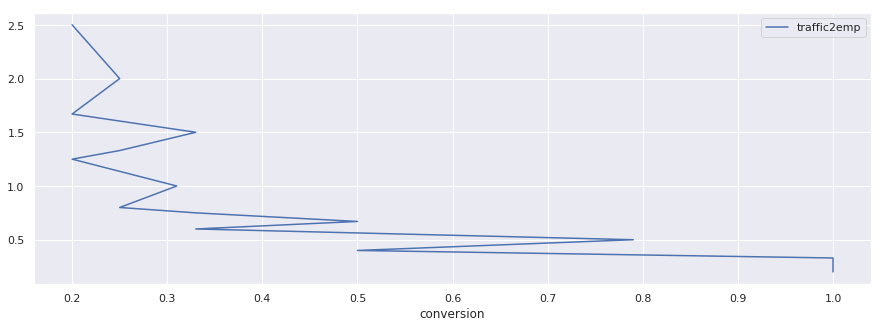

In [231]:
df_t_c.plot(kind='line',x='conversion',y='traffic2emp')

In [139]:

def get_emp_needed(oneEmp=1.5,twoEmp=3,threeEmp=4.5):
    df_emp_needed= pd.read_sql_query("""
select *,
       CASE
                  when a.avg_traffic <={} THEN 1
                  when a.avg_traffic <={} THEN 2
                  when a.avg_traffic <={} THEN 3
                  when a.avg_traffic > {} THEN 4
                  END as Employee_needed
from (
         select date_part('dow', date)                          as Day,
                time,
               -- state,
                round(avg(cast(traffic.traffic as decimal)), 2) as avg_traffic
         from traffic
         where 
         --state = 'England'
         country ='United States'
         and time >= '09:00:00' and time <= '21:00:00'
         group by date_part('dow', date), time --,state
     ) a
ORDER by a.Day, time;
""".format(oneEmp,twoEmp,threeEmp,threeEmp), cnx)
    return df_emp_needed

In [194]:
## Basic Optimization using simple Back Propagation

def total_hours_known(oneEmp=1.5,twoEmp=3,threeEmp=4.5,total_hours=220,learning_rate=0.1):
    oneEmp_local=oneEmp
    twoEmp_local=twoEmp
    threeEmp_local=threeEmp
    oneEmp_local_old=0
    twoEmp_local_old=0
    threeEmp_local_old=0
    increaseParameters=''
    decreaseParameters=''
    opt_sol_flag=""
    n=0
    
    while opt_sol_flag=="":
        n=n+1
        print(oneEmp_local,twoEmp_local)
        df_store_sch=get_emp_needed(oneEmp=oneEmp_local,twoEmp=twoEmp_local,threeEmp=threeEmp_local)
      #  print("1", df_store_sch.employee_needed.sum())
        df_store_sch=df_store_sch.pivot(columns='time',values='employee_needed',index='day')
        df_store_sch.fillna(1,inplace=True)
        print("Total Hours:",df_store_sch.sum().sum(), "n=",n)
        
        if (increaseParameters=='X') & (decreaseParameters=='X'):
            break
        elif df_store_sch.sum().sum()==total_hours:
            break
        elif df_store_sch.sum().sum()<total_hours:
            oneEmp_local_old=oneEmp_local
            twoEmp_local_old=twoEmp_local
            threeEmp_local_old=threeEmp_local
            
            if oneEmp_local > learning_rate:
                oneEmp_local=round(oneEmp_local-learning_rate,2)
            if twoEmp_local > learning_rate:
                twoEmp_local=round(twoEmp_local-learning_rate,2)
            if threeEmp_local > learning_rate:
                threeEmp_local=round(threeEmp_local-learning_rate,2)    
            decreaseParameters='X'
            continue
        elif df_store_sch.sum().sum()>total_hours:
            oneEmp_local_old=oneEmp_local
            twoEmp_local_old=twoEmp_local
            oneEmp_local=round(oneEmp_local+learning_rate,2)
            twoEmp_local=round(twoEmp_local+learning_rate,2)
            threeEmp_local=round(threeEmp_local+learning_rate,2)
            increaseParameters='X'
            continue
        elif n==360: # Safety against Endless Loop 
            break
            
    latest_parameters_sum=df_store_sch.sum().sum()
    df_store_sch=get_emp_needed(oneEmp=oneEmp_local_old,twoEmp=twoEmp_local_old,threeEmp=threeEmp_local_old)
    df_store_sch=df_store_sch.pivot(columns='time',values='employee_needed',index='day')
    old_parameters_sum=df_store_sch.sum().sum()
    latest_parameters_sum=abs(latest_parameters_sum-total_hours)
    old_parameters_sum=abs(old_parameters_sum-total_hours)
    
    if latest_parameters_sum > old_parameters_sum:
        print("Optimized Solution found: oneEmp:",oneEmp_local_old, "twoEmp:", twoEmp_local_old,"threeEmp:",threeEmp_local_old)
        df_store_sch=get_emp_needed(oneEmp=oneEmp_local_old,twoEmp=twoEmp_local_old,threeEmp=threeEmp_local_old)
    else:
        print("Optimized Solution found: oneEmp:",oneEmp_local, "twoEmp:", twoEmp_local,"threeEmp:",threeEmp_local )
        df_store_sch=get_emp_needed(oneEmp=oneEmp_local,twoEmp=twoEmp_local,threeEmp=threeEmp_local)
        
    return df_store_sch

In [195]:
df_emp_needed= get_emp_needed(oneEmp=1.5,twoEmp=3,threeEmp=4.5)
df_emp_needed.head()

,day,time,avg_traffic,employee_needed
0,0.0,09:00:00,4.00,3
1,0.0,10:00:00,2.25,2
2,0.0,11:00:00,2.50,2
3,0.0,12:00:00,3.25,3
4,0.0,13:00:00,3.00,2


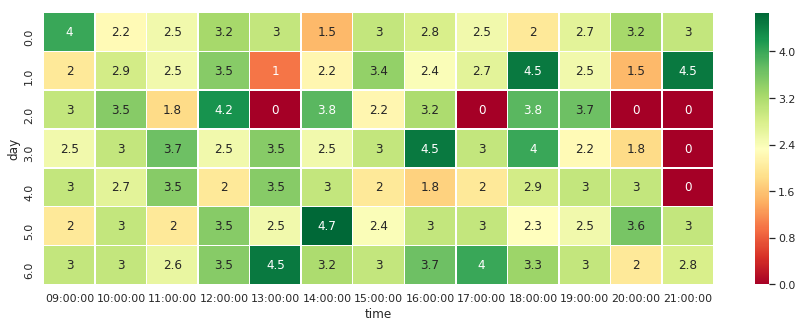

In [196]:
# Lets see the traffic need on hourly basis
df_avg_traffic=df_emp_needed.pivot(columns='time',values='avg_traffic',index='day')
df_avg_traffic.fillna(0,inplace=True)
sns.heatmap(df_avg_traffic, cmap='RdYlGn', linewidths=0.5, annot=True)

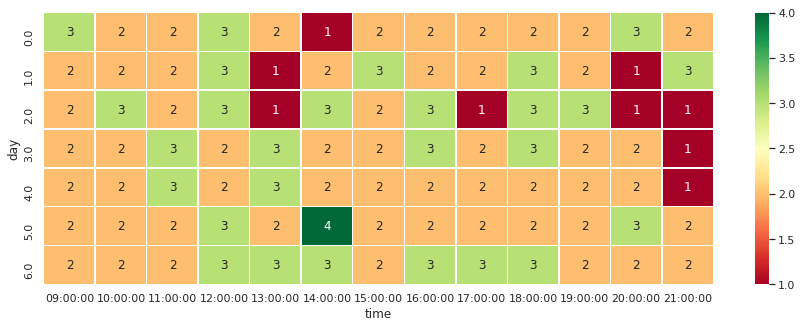

In [197]:
df_emp_needed2=df_emp_needed.pivot(columns='time',values='employee_needed',index='day')
df_emp_needed2.fillna(1,inplace=True)
#df_emp_needed2=df_emp_needed2.replace(0, 1)
sns.heatmap(df_emp_needed2, cmap='RdYlGn', linewidths=0.5, annot=True)

In [199]:
print(df_emp_needed2.sum().sum())
#print(df_emp_needed.employee_needed.sum())

202.0


In [200]:
df_emp_needed=total_hours_known(total_hours=175)

1.5 3
Total Hours: 202.0 n= 1
1.6 3.1
Total Hours: 202.0 n= 2
1.7 3.2
Total Hours: 199.0 n= 3
1.8 3.3
Total Hours: 196.0 n= 4
1.9 3.4
Total Hours: 192.0 n= 5
2.0 3.5
Total Hours: 177.0 n= 6
2.1 3.6
Total Hours: 176.0 n= 7
2.2 3.7
Total Hours: 171.0 n= 8
2.1 3.6
Total Hours: 176.0 n= 9
Optimized Solution found: oneEmp: 2.1 twoEmp: 3.6 threeEmp: 5.1


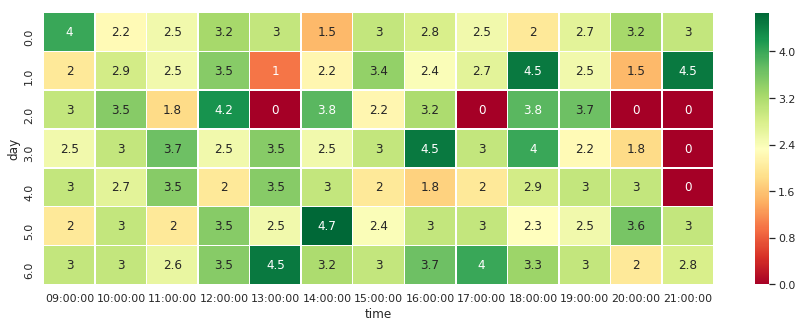

In [201]:
# Lets see the traffic need on hourly basis
df_avg_traffic=df_emp_needed.pivot(columns='time',values='avg_traffic',index='day')
df_avg_traffic.fillna(0,inplace=True)
sns.heatmap(df_avg_traffic, cmap='RdYlGn', linewidths=0.5, annot=True)

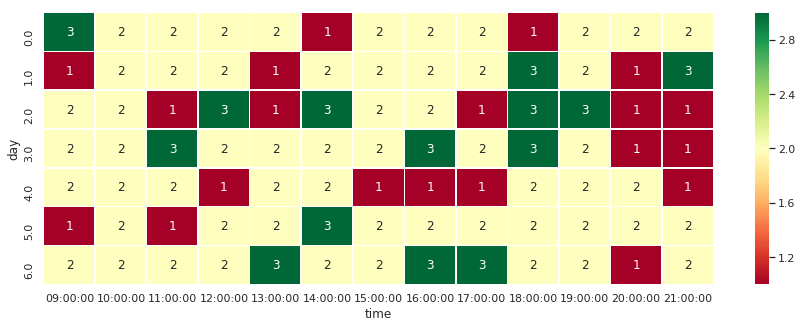

In [202]:
df_emp_needed2=df_emp_needed.pivot(columns='time',values='employee_needed',index='day')
df_emp_needed2.fillna(1,inplace=True)
sns.heatmap(df_emp_needed2, cmap='RdYlGn', linewidths=0.5, annot=True)

In [203]:
print(df_emp_needed2.sum().sum())
#print(df_emp_needed.employee_needed.sum())

176.0


In [204]:
def getMaxEmpNeeded(i,df,two=18,three=25,four=40):
    
    emp_needed=1
        
    if df.loc[df.index==i].transpose().sum().values[0].astype(int) < two:
        emp_needed=2
    elif df.loc[df.index==i].transpose().sum().values[0].astype(int) < three: 
        emp_needed=3
    elif df.loc[df.index==i].transpose().sum().values[0].astype(int) < four: 
        emp_needed=4
    else:
        emp_needed=5
        
    if  df.loc[df.index==i].transpose().max().values[0].astype(int) > emp_needed:
        emp_needed = df.loc[df.index==i].transpose().max().values[0].astype(int)
        
    return emp_needed

In [216]:
def getDayAllocation(employee_names,shift_requirements,n_days=7,max_seq=5,min_seq=1,max_work=6,min_work=3,max_weekend=2):

    #n_days = 7  # number of days
    days = list(range(n_days))
    #max_seq = 5  # max number of consecutive shifts
    #min_seq = 1  # min sequence without gaps
    #max_work = 6  # max total number of shifts
    #min_work = 3  # min total number of shifts
    #max_weekend = 2  # max number of weekend shifts

    # Create employee scheduling scenari
    S = Scenario('employee_scheduling', horizon=n_days)

    # Create employees as resources indexed by namesc
    employees = {name: S.Resource(name) for name in employee_names}

    # Create shifts as tasks
    shifts = {(day, i): S.Task('S_%s_%s' % (str(day), str(i)))
              for day in shift_requirements if day in days
              for i in range(shift_requirements[day])}

    # distribute shifts to days
    for day, i in shifts:
        # Assign shift to its day
        S += shifts[day, i] >= day
        # The shifts on each day are interchangeable, so add them to the same group
        shifts[day, i].group = day
        # Weekend shifts get attribute week_end
        if day % 7 in {0, 6}:  # it was {5,6}
            shifts[day, i].week_end = 1

    # There are no restrictions, any shift can be done by any employee
    for day, i in shifts:
        shifts[day, i] += alt(S.resources())
        # print(shifts[day,i],alt( S.resources() ))

    # Capacity restrictions
    for name in employees:
        if (name == 'SM' or name == 'ASM'):
            # Maximal number of shifts
            S += employees[name] <= 5
            # Minimal number of shifts
            S += employees[name] >= 5
            # Maximal number of weekend shifts using attribute week_end
            S += employees[name]['week_end'] <= 1
        else:
            # Maximal number of shifts
            S += employees[name] <= max_work
            # Minimal number of shifts
            S += employees[name] >= min_work
            # Maximal number of weekend shifts using attribute week_end
            S += employees[name]['week_end'] <= max_weekend

    # Max number of consecutive shifts
    for name in employees:
        for day in range(n_days):
            S += employees[name][day:day + max_seq + 1] <= max_seq

    # Min sequence without gaps
    for name in employees:
        # No increase in last periods
        S += employees[name][n_days - min_seq:].inc <= 0
        # No decrease in first periods
        S += employees[name][:min_seq].dec <= 0
        # No diff during time horizon
        for day in days[:-min_seq]:
            S += employees[name][day:day + min_seq + 1].diff <= 1

    # Solve and plot scenario
    d={}
    if solvers.mip.solve(S, kind='CBC', msg=0, random_seed=6):

       # plotters.matplotlib.plot(S, fig_size=(12, 5))
        solutionList = S.solution()
        for tup in solutionList:
            d.setdefault(tup[2] + 1, []).append(str(tup[1]))
    else:
        print('no solution found')


    return(d)

In [217]:
schDict={}
for i in range(df_emp_needed2.shape[0]):
    schDict.update({i: getMaxEmpNeeded(i,df_emp_needed2)})

In [218]:
print(schDict)

{0: 4, 1: 4, 2: 4, 3: 4, 4: 3, 5: 4, 6: 4}


In [219]:
availabilityMatrix={}
for i in [['SM','ASM','KH'],['SM','ASM','KH','HE1'],['SM','ASM','KH','HE1','HE2'],['SM','ASM','KH','HE1','HE2','HE3']]:
    availabilityMatrix=getDayAllocation(i, schDict)
    if len(availabilityMatrix) > 0:
        break
print(availabilityMatrix)

no solution found
no solution found
{1: ['ASM', 'KH', 'HE1', 'HE2'], 2: ['SM', 'ASM', 'KH', 'HE2'], 3: ['SM', 'ASM', 'KH', 'HE1'], 4: ['SM', 'ASM', 'HE1', 'HE2'], 5: ['ASM', 'HE1', 'HE2'], 6: ['SM', 'KH', 'HE1', 'HE2'], 7: ['SM', 'KH', 'HE1', 'HE2']}


In [220]:
def find_feasible_sch(employee_names, n_hours, hours, max_seq,min_seq,max_work,min_work,shift_requirements,Weekday):
    
    ## Return variable
    df=pd.DataFrame(columns=['Title', 'TimeSlot','Available','Day'])
    feasibility_flag=''
    shift_requirements2=shift_requirements
    for i in shift_requirements:
        try:
            if shift_requirements[i-1]==shift_requirements[i+1]:
                if shift_requirements[i-1] != shift_requirements[i]:
                    shift_requirements[i]=shift_requirements[i-1]
                    feasibility_flag='X'
                    break
        except:
            continue
    if feasibility_flag=='':
        shift_requirements, feasibility_flag = find_feasible_sch2(shift_requirements2)
        if feasibility_flag=='X':
        #    print("Feasible Solution:",shift_requirements) 
         df =  build_schedule(employee_names,n_hours,hours, 
                   max_seq,min_seq,max_work,min_work,shift_requirements,Weekday)
    else:    
      #  print("Feasible Solution:",shift_requirements) 
        df=build_schedule(employee_names,n_hours,hours, 
                   max_seq,min_seq,max_work,min_work,shift_requirements,Weekday) 
    
    return df

In [221]:
def find_feasible_sch2(shift_requirements):
    feasibility_flag=''
    for i in shift_requirements:
        try:
            if (shift_requirements[i]!=shift_requirements[i+1]):
                shift_requirements[i]=shift_requirements[i+1]
                feasibility_flag='X'
                break
        except:
            continue
    if feasibility_flag=='':
        print(shift_requirements)
        print("No feasible solution")
    
    return(shift_requirements, feasibility_flag)

In [222]:
def build_schedule(employee_names, n_hours, hours, max_seq,min_seq,max_work,min_work,shift_requirements,Weekday):
    
    ## Return variable
    df=pd.DataFrame(columns=['Title', 'TimeSlot','Available','Day'])
    
    # Create employee scheduling scenarios
    S = Scenario('employee_scheduling',horizon=n_hours)

# Create enployees as resources indexed by namesc
    employees = { name : S.Resource(name) for name in employee_names }

# Create shifts as tasks
    shifts = { (day,i) : S.Task('S_%s_%s'%(str(day),str(i))) 
          for day in shift_requirements if day in hours
          for i in range(shift_requirements[day]) }

# distribute shifts to days
    for day,i in shifts:
    # Assign shift to its day
        S += shifts[day,i] >= day
    # The shifts on each day are interchangeable, so add them to the same group
        shifts[day,i].group = day
    # Weekend shifts get attribute week_end
      #  if day % 7 in {5,6}:
        #    shifts[day,i].week_end = 1

# There are no restrictions, any shift can be done by any employee
    for day,i in shifts:
        shifts[day,i] += alt( S.resources() )
    
# Capacity restrictions
    for name in employees:
        if name=='SM' or name=='ASM':
    # Maximal number of shifts
            S += employees[name] <= 9
    # Minimal number of shifts
            S += employees[name] >= 7      
        else:
          #  print(min_work,max_work)
    # Maximal number of shifts
            S += employees[name] <= max_work
    # Minimal number of shifts
            S += employees[name] >= min_work
    # Maximal number of weekend shifts using attribute week_end
         #   S += employees[name]['week_end'] <= max_weekend
    

# Max number of consecutive shifts
    for name in employees:
        for day in range(n_hours):
            S += employees[name][day:day+max_seq+1] <= max_seq

# Min sequence without gaps
    for name in employees:
        if (name=='SM' or name =='ASM'):
            min_seq2=8
        # No increase in last periods
            S += employees[name][n_hours-min_seq2:].inc <= 0
    # No decrease in first periods
            S += employees[name][:min_seq2].dec <= 0
    # No diff during time horizon
            for day in hours[:-min_seq2]:
                S += employees[name][day:day+min_seq2+1].diff <= 1
        else:        
    # No increase in last periods
            S += employees[name][n_hours-min_seq:].inc <= 0
    # No decrease in first periods
            S += employees[name][:min_seq].dec <= 0
    # No diff during time horizon
            for day in hours[:-min_seq]:
                S += employees[name][day:day+min_seq+1].diff <= 1
        
# Solve and plot scenario
    if solvers.mip.solve(S,kind='CBC',msg=0,random_seed=6):
      #  %matplotlib inline
        plotters.matplotlib.plot(S,fig_size=(12,5))
        solutionList=S.solution()
        sList=[]
        for i in solutionList:
            sList.append(tuple((str(i[1]),i[2]+9,1,Weekday)))
        df=pd.DataFrame(sList, columns=['Title', 'TimeSlot','Available','Day']) 
        print("Feasible total_hours:", df.Available.sum())
        df2=df.pivot(columns='TimeSlot',values='Available',index='Title')
        df2.fillna(0,inplace=True)
      #  sns.heatmap(df2, cmap='Pastel2', linewidths=0.5, annot=True)
    else:
        print('no solution found')
        df=find_feasible_sch(employee_names, n_hours, hours, max_seq,min_seq,max_work,min_work,shift_requirements,Weekday)
        
    return(df)

################################
Schedule for  Sunday
Employee Availability : ['ASM', 'KH', 'HE1', 'HE2']
Ideal Hourly need: [3. 2. 2. 2. 2. 1. 2. 2. 2. 1. 2. 2. 2.]
Ideal Total Hours: 25.0
no solution found
no solution found
no solution found


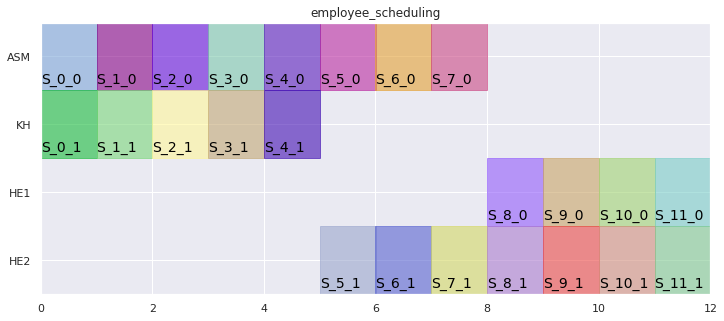

Feasible total_hours: 24
################################
Schedule for  Monday
Employee Availability : ['SM', 'ASM', 'KH', 'HE2']
Ideal Hourly need: [1. 2. 2. 2. 1. 2. 2. 2. 2. 3. 2. 1. 3.]
Ideal Total Hours: 25.0
no solution found


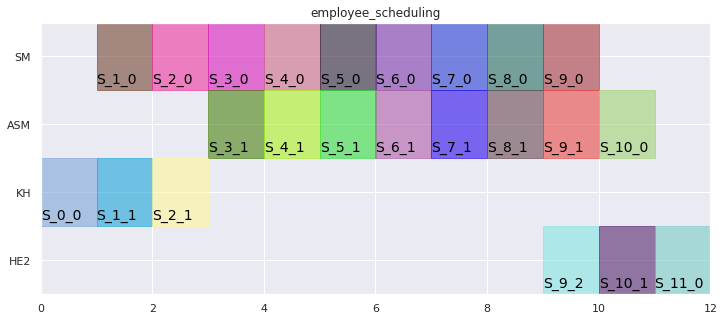

Feasible total_hours: 23
################################
Schedule for  Tuesday
Employee Availability : ['SM', 'ASM', 'KH', 'HE1']
Ideal Hourly need: [2. 2. 1. 3. 1. 3. 2. 2. 1. 3. 3. 1. 1.]
Ideal Total Hours: 25.0
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found


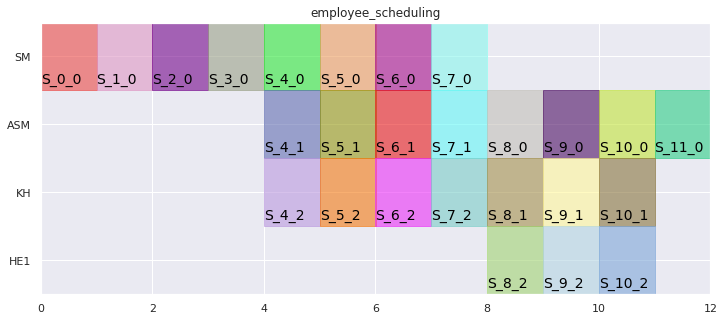

Feasible total_hours: 26
################################
Schedule for  Wednesday
Employee Availability : ['SM', 'ASM', 'HE1', 'HE2']
Ideal Hourly need: [2. 2. 3. 2. 2. 2. 2. 3. 2. 3. 2. 1. 1.]
Ideal Total Hours: 27.0


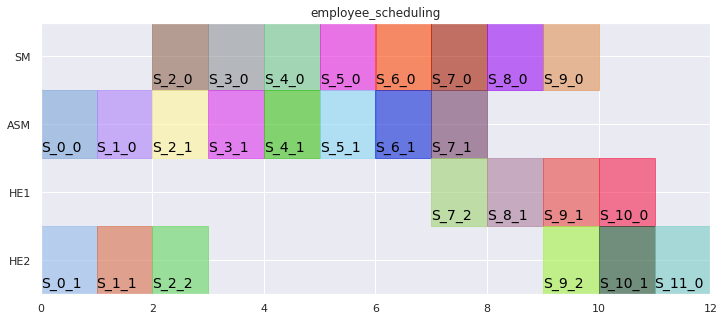

Feasible total_hours: 26
################################
Schedule for  Thursday
Employee Availability : ['ASM', 'HE1', 'HE2']
Ideal Hourly need: [2. 2. 2. 1. 2. 2. 1. 1. 1. 2. 2. 2. 1.]
Ideal Total Hours: 21.0


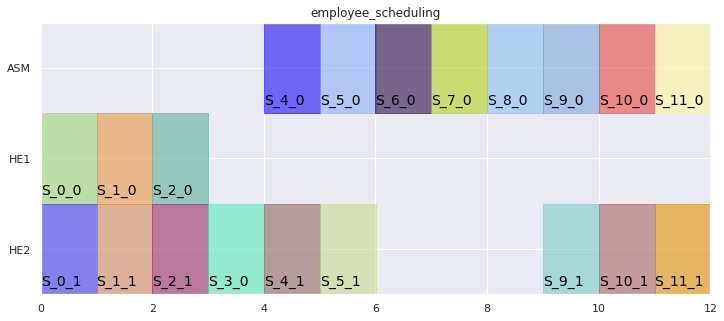

Feasible total_hours: 20
################################
Schedule for  Friday
Employee Availability : ['SM', 'KH', 'HE1', 'HE2']
Ideal Hourly need: [1. 2. 1. 2. 2. 3. 2. 2. 2. 2. 2. 2. 2.]
Ideal Total Hours: 25.0
no solution found


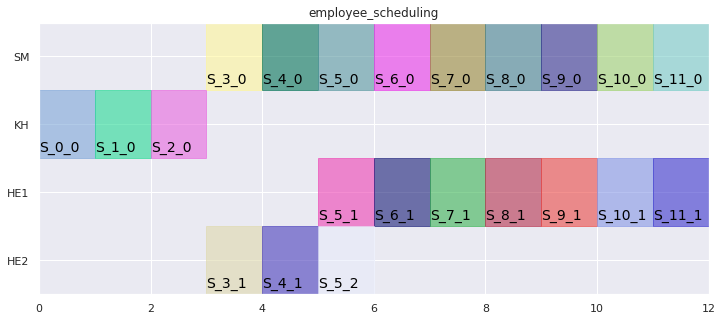

Feasible total_hours: 22
################################
Schedule for  Saturday
Employee Availability : ['SM', 'KH', 'HE1', 'HE2']
Ideal Hourly need: [2. 2. 2. 2. 3. 2. 2. 3. 3. 2. 2. 1. 2.]
Ideal Total Hours: 28.0


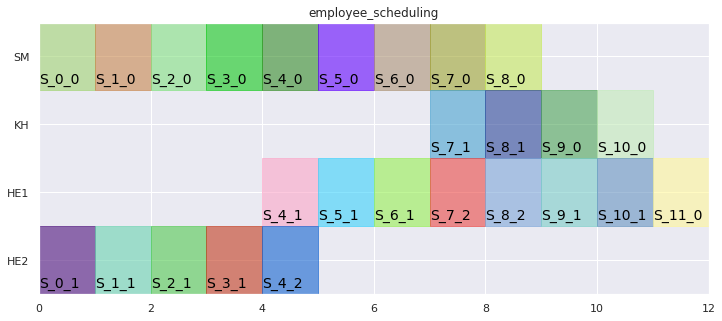

Feasible total_hours: 26


In [223]:
# WeekdayDictionary
dayDict={1 : 'Sunday',2 : 'Monday',3 : 'Tuesday',4 : 'Wednesday', 5 :'Thursday', 6:'Friday',7:'Saturday'}

# Employee Availability Matrix
#availabilityMatrix = {1:['ASM','KH','HE1','HE2'],2:['SM','ASM','HE2'],3:['ASM','KH','HE1'],4:['SM','KH','HE2'],
 #                    5:['SM','KH','HE1'],6:['SM','ASM','KH'],7:['SM','KH','HE1','ASM']}

# Dictionary  for Shift Requirement with dummy values
shift_requirements =\
{0: 2,1: 2,2: 2,3: 2,4: 3,5: 3,6: 3, 7: 3,8: 3,9: 2,10: 2,11: 2}

# Other Constraints
n_hours = 12 # Total number of hours in a days for which store would be open
hours = list(range(n_hours))
max_seq = 9 # max number of consecutive shifts
min_seq = 3 # min sequence without gaps
max_work = 10 # max total number of shifts
min_work = 3 # min total number of shifts

df_solution=pd.DataFrame(columns=['Title', 'TimeSlot','Available','Day'])

for (idx, row) in df_emp_needed2.iterrows():
    print("################################")
    print("Schedule for ",dayDict[idx+1])
    print("Employee Availability :",availabilityMatrix[idx+1])
    employee_names=availabilityMatrix[idx+1]
   # print(row)
    key=0
    for i in row.astype('int').values:
        shift_requirements[key] = i
        key=key+1
    print("Ideal Hourly need:", row.values)
    print("Ideal Total Hours:",row.values.sum())
    df=build_schedule(employee_names,n_hours,hours, 
                   max_seq,min_seq,max_work,min_work,shift_requirements,idx) 
    if df.shape[0] > 1:
        df_solution=df_solution.append(df)
        


In [131]:
def get_weekday_sch(day,df):
    
    df2=df.loc[df['Day']==day]
    df2=df2.pivot(columns='TimeSlot',values='Available',index='Title')
    df2.fillna(0,inplace=True)
    print("Schedule for ",dayDict[day])
    return df2

Schedule for  Sunday


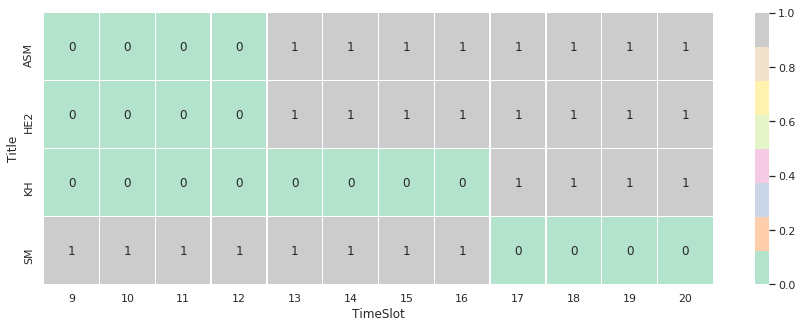

In [132]:
df_sunday=get_weekday_sch(1,df_solution)
sns.heatmap(df_sunday, cmap='Pastel2', linewidths=0.5, annot=True)

\begin{equation*} Conversion =
\left( \sum_{hour=1}^h (Tc / Tr) \right)
\end{equation*}